In [1]:
from __future__ import division

import pandas as pd
import numpy as np
import csv
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import os
import csv
from collections import OrderedDict
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.stats import ttest_ind
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [2]:
def text_clean(filename):
    '''
    Input: File path of script.
    Output: List of all words in script lowercased, lemmatized, without punctuation.
    '''
    wnl = WordNetLemmatizer()
    word_list = [word.decode("utf8", errors='ignore') for line in open(filename, 'r') for word in line.split()]
    lemma_list = [wnl.lemmatize(word.lower()) for word in word_list]
    return lemma_list

In [3]:
def windows(text_list, size=100):
    '''
    Input:
    text_list = List of cleaned words
    size = size of window

    Output:
    Text as list of windows of size=size.
    '''

    windows = []
    for i in xrange(0,len(text_list)-size,size):
        window = text_list[i:i+size]
        window = " ".join(window)
        windows.append(window)

    return windows

In [4]:
def quick_n_dirty_polarity(text):
    '''
    Input: Text to get sentiment.
    Output: List of sentiment scores.
    '''
    blob = TextBlob(text)
    sentiments = []
    for sentence in blob.sentences:
        sentiments.append(sentence.sentiment.polarity)
    return sentiments

In [5]:
def dirty_windows(window_list):
    '''
    Get polarity score for each window in a list.
    '''
    window_sents = []
    for window in window_list:
        sent_list = quick_n_dirty_polarity(window)
        window_sents.append(np.mean(sent_list))
    return window_sents

In [6]:
def get_script_filepaths():
    '''
    Get list of filepaths to each script to input into cleaning function.
    '''
    scripts = os.listdir('scripts')
    paths = []
    for script in scripts:
        new_path = 'scripts/{}'.format(script)
        paths.append(new_path)
    return paths

In [20]:
def make_array(paths, number_movies, window_divisor):
    '''
    Inputs: paths = list of filepaths to movie scripts
    number_movies = how many you want to do this time (keep low for testing so it doesn't take forever!)
    window_divisor = We will divide the length of the movie by this to get a proportionally sized window for each movie.  Works best under about 10.
    '''

    movie_list = paths[0:number_movies]

    movie_names = []
    list_movie_meanwindowsent = []
    for movie in movie_list:
        clean_movie = text_clean(movie)
        if len(clean_movie) > 200:
            movie_windows = windows(clean_movie, int(len(clean_movie)/window_divisor + 1))
            window_polarity = dirty_windows(movie_windows)
            if len(window_polarity) == window_divisor-1:
                list_movie_meanwindowsent.append(window_polarity)
                movie_names.append(movie)

    #Make it just the name of the movie instead of the whole filepath
    for i,value in enumerate(movie_names):
        movie_names[i] = value.replace(value, value[8:-4])

    X = np.array(list_movie_meanwindowsent)
    movie_names = np.array(movie_names)

    return X, movie_names

In [21]:
def deltas(X):
    '''
    Input: Array of sentiment levels (each row is a movie, each column is a window).
    Output: Array that is one column less that is the difference between each window.
    '''
    diff_array = []
    for row in X:
        diff_array.append(np.diff(row))

    diff_array = np.array(diff_array)
    diff_array = preprocessing.scale(diff_array)
    return diff_array

In [33]:
def cluster_predictions(n_clusters, random_state, diff_array, omit_ending=False):
    '''
    Input: Number of clusters, random state of model, array of deltas, and
    boolean on whether to omit the last sentiment window when fitting the model
    for future prediction of ending.
    Output: vector of predicted clusters, array with data and cluster.
    '''

    if omit_ending == False:
        model = KMeans(n_clusters=n_clusters, n_jobs=-2, random_state=random_state)
        predictions = model.fit_predict(diff_array)
        #
        # #Add the predicted clusters as the last column of the data frame.
        X_and_pred = np.column_stack((diff_array, predictions))
        print "the shape of diff array plus cluster number is:"
        print X_and_pred.shape

        return predictions, X_and_pred
    
    elif omit_ending==True:
        
        #Save ending column as ending
        ending = diff_array[:,-1:]
        
        #Remove last column for ending
        diff_array = diff_array[:,:-1]
        
        model = KMeans(n_clusters=n_clusters, n_jobs=-2, random_state=random_state)
        predictions = model.fit_predict(diff_array)
        #
        # #Add the predicted clusters as the last column of the data frame.
        X_and_pred = np.column_stack((diff_array, predictions))
        print "the shape of diff array plus cluster number is:"
        print X_and_pred.shape

        return predictions, X_and_pred, ending
        

In [23]:
def reg_title(title):
    if title.split()[0] == 'The':
        rest = '-'.join(title.split()[1:])
        title = ''.join([rest, ',-The'])
    else:
        title = title.replace(" ", "-")
    return title

In [24]:
def add_features(X_and_pred, movie_names):
    '''
    Ignore this weird function.  Am doing it a different way now, will update soon.
    '''
    cols = []
    for i,column in enumerate(X_and_pred.T):
        col_name = 'window_{}'.format(i)
        cols.append(col_name)

    cols[-1] = cols[-1].replace(cols[-1], 'predicted_cluster')

    df = pd.DataFrame(X_and_pred, columns=cols)
    df['title'] = movie_names

    gross = pd.read_csv('movie_gross.csv')
    genre = pd.read_csv('movie_genre.csv')
    year = pd.read_csv('movie_year.csv')

    df = df.merge(gross,on='title').merge(genre,on='title').merge(year,on='title')

    return df

In [25]:
def oh_no_test(df, n_clusters):
    clusters = []
    for i in range(n_clusters):
        print "cluster {}".format(i)
        print df[df['predicted_cluster']==float(i)].shape
        cluster = df[df['predicted_cluster']==float(i)]
        print "movies"
        print cluster['title'].head(3)

In [26]:
def make_splits(X, index):
    #Split dataframe based on what topic
    return X[X[:,-1] == float(index), :]

In [27]:
def cluster_plot(X_and_pred, predictions, limit=5):

    output = {}

    for prediction in np.unique(predictions):
        title = "group_{}".format(prediction)
        output[title] = make_splits(X_and_pred, prediction)[:,:-1]

    for group in output.keys():
        print len(output[group])


    #Take mean for each cluster at each window
    means_array = []
    for group in output.keys():
        if len(output[group]) >= limit:
            mean_group = np.mean(output[group], axis=0)
            means_array.append(mean_group)

    #Turn it back into an array
    means_array = np.array(means_array)

    #Not sure when I transposed this, but better transpose it back:
    means_array = means_array.T

    #Scale or else everything will be bad
    means_array = preprocessing.scale(means_array)

    # #SHOW THE MOVIE MAGIC!
    plt.plot(means_array)
    plt.show()


In [40]:
def happy_or_sad(x):
    '''
    This function is to apply to the vector of ending sentiments to classify as happy ending or not.
    Input: Any float
    Output: 1 if number is positive, 0 if negative.
    '''
    if x >= 0:
        return 1
    elif x < 0:
        return 0

In [56]:
paths = get_script_filepaths()

In [57]:
window_divisor = 6
n_clusters = 4 #3 clusters and 6 clusters are bad, haven't tried 5
rs = 456
subset = len(paths) #for all movies
#subset = 20

In [355]:
#Start running here
sent_array, movie_names = make_array(paths, subset, window_divisor=window_divisor)

In [360]:
#Sent ending is the straight sentiment score for the last window.
sent_ending = sent_array[:, -1:]

(1034, 5)

In [ ]:
diff_array = deltas(sent_array)

In [60]:
#Ending is the delta score for the last window.
predictions, X_and_pred, ending = cluster_predictions(n_clusters=n_clusters, random_state=rs, diff_array=diff_array, omit_ending=True)

the shape of diff array plus cluster number is:
(1034, 4)


In [430]:
#This will be the target prediction, whether movie is happy or not.
sent_happy = []

#Change sent_ending back to ending if you want to test on deltas instead of raw sentiment

for movie in sent_ending:
    sent_happy.append(happy_or_sad(movie))

#This will be the target prediction, whether movie is happy or not.
delta_happy = []

#Change sent_ending back to ending if you want to test on deltas instead of raw sentiment

for movie in ending:
    delta_happy.append(happy_or_sad(movie))



In [439]:
print delta_happy[0:10]
print sent_happy[0:10]

[0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 1, 0, 0]


In [363]:
print X_and_pred.shape

(1034, 4)


In [441]:
#Continue running here
df = add_features(X_and_pred, movie_names)
df['delta_target'] = delta_happy
df['sent_target'] = sent_happy
df.to_csv('data131.csv',index=False)

In [64]:
print oh_no_test(df, n_clusters)

cluster 0
(214, 9)
movies
1     12-and-Holding
6         15-Minutes
10              2012
Name: title, dtype: object
cluster 1
(237, 9)
movies
9     2001-A-Space-Odyssey
16      500-Days-of-Summer
23              Abyss,-The
Name: title, dtype: object
cluster 2
(247, 9)
movies
7           17-Again
15             50-50
19    A-Few-Good-Men
Name: title, dtype: object
cluster 3
(336, 9)
movies
0    10-Things-I-Hate-About-You
2                    12-Monkeys
3              12-Years-a-Slave
Name: title, dtype: object
None


336
247
237
214


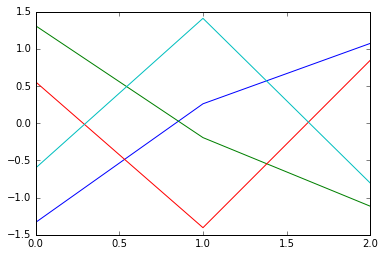

In [65]:
cluster_plot(X_and_pred, predictions, limit=5)

## FROM test_clusters FILE

In [66]:
def make_dummies(df):
    '''
    Input: dataframe
    Output: Same dataframe, but with dummy variables indicating which cluster each row belongs to.
    '''
    cluster_dummies = pd.get_dummies(df['predicted_cluster']).rename(columns = lambda x: 'cluster_'+str(x))
    df = pd.concat([df, cluster_dummies], axis=1)
    return df

def dollars_to_floats(x):
    '''
    Input: A dollar amount string (e.g. $4,000,000)
    Output: As a float (e.g. 4000000.0)
    '''
    if x:
        if str(x)[0] == '$':
            x = x[1:] #remove dollar sign
            x = ''.join(x.split(','))
            x = float(x)

        else:
            pass

        return x

def genre_dummies(df):
    '''
    Input: Dataframe.
    Output: Same dataframe, but with dummy variables for each genre.  Movies can belong to more than one genre.
    '''
    big_genre_list = []
    #First, get the unique genres.
    for entry in df['genre']: #Each "entry" is a list of genres.
        if entry:
            entry = ''.join(c for c in str(entry) if c not in "[]''u,").split(' ')
            for g in entry: #Iterate through that list.
                big_genre_list.append(g)

    genres = set(big_genre_list) #Gets each unique genre.

    #Create variable in df for each genre.
    for genre1 in genres:
        df[genre1] = 0

    #Now add flag for each movie in each genre.
    for genre1 in genres:
        for i, entry in enumerate(df['genre']):
            entry = ''.join(c for c in str(entry) if c not in "[]''u,").split(' ')
            if genre1 in entry:
                df[genre1][i] = 1
            else:
                pass
    return genres, df

In [442]:
#Begin running here
df = pd.read_csv('data131.csv')
df['gross'] = df['gross'].apply(dollars_to_floats)
num_clusters = len(df['predicted_cluster'].unique())
genres, df_with_genre = genre_dummies(df)

/Users/demetriamcaleer/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [478]:
df_with_genre = df_with_genre.set_index(df_with_genre['title'])
df_with_genre = df_with_genre.drop(['title', 'genre'], 1)
print df_with_genre.shape
new_df_with_genre = df_with_genre.dropna(axis=0, how='any')
print new_df_with_genre.shape
new_df_with_genre.columns

(1034, 34)
(810, 34)


Index([u'window_0', u'window_1', u'window_2', u'predicted_cluster', u'gross',
       u'year', u'delta_target', u'sent_target', u'Sci-Fi', u'Crime',
       u'Romance', u'Animation', u'Msic', u'Comedy', u'War', u'Horror', u'nan',
       u'Film-Noir', u'Msical', u'Reality-TV', u'Thriller', u'Western',
       u'Mystery', u'Short', u'Talk-Show', u'Drama', u'Action', u'History',
       u'Family', u'Adventre', u'Docmentary', u'Fantasy', u'Sport',
       u'Biography'],
      dtype='object')

In [492]:
print new_df_with_genre['delta_target'].head()
print new_df_with_genre['sent_target'].head()

title
10-Things-I-Hate-About-You    0
12-and-Holding                1
12-Years-a-Slave              1
127-Hours                     0
1492-Conquest-of-Paradise     0
Name: delta_target, dtype: int64
title
10-Things-I-Hate-About-You    1
12-and-Holding                1
12-Years-a-Slave              1
127-Hours                     0
1492-Conquest-of-Paradise     0
Name: sent_target, dtype: int64


In [693]:

X = new_df_with_genre[[u'predicted_cluster', u'gross',
       u'year', u'Sci-Fi',
       u'Romance', u'Comedy', u'Horror', u'Thriller', u'Drama', u'Action',
       u'Family', u'Adventre']]

## Fit models

In [694]:
#Make train-test-split out of paths and define sentiment of final window as target



#X = new_df.drop(['target'], axis=1)
y = new_df.ix[:, df.columns == 'delta_target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=456)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(542, 12) (268, 12) (542, 1) (268, 1)


In [695]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

### Random forest

In [696]:
#2. Fit a random forest model on the train data trying to predict.
#Use box office, genre, year, and cluster.
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=False, n_jobs=1, random_state=456, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=456, verbose=0, warm_start=False)

In [697]:
#3. Test the RF model on the test data, see how it does.
rf_model.score(X_test, y_test)

0.59701492537313428

In [698]:
y_pred = rf_model.predict(X_test)

In [699]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [700]:
print "accuracy"
print accuracy_score(y_test, y_pred)
print "f1"
print f1_score(y_test, y_pred)
print "precision"
print precision_score(y_test, y_pred)
print "recall"
print recall_score(y_test, y_pred)

accuracy
0.597014925373
f1
0.64
precision
0.644295302013
recall
0.635761589404


In [701]:
rf_model.feature_importances_

array([ 0.12129166,  0.34363516,  0.26735388,  0.0260841 ,  0.03458145,
        0.03585091,  0.02069194,  0.03467137,  0.03781716,  0.03187182,
        0.01673242,  0.02941813])

In [702]:
sum(np.ravel(y))/len(np.ravel(y))

0.53580246913580243

In [703]:
from sklearn.ensemble import GradientBoostingClassifier

In [704]:
gb_model = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=456, subsample=1.0, verbose=0,
              warm_start=False)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=456, subsample=1.0, verbose=0,
              warm_start=False)

In [705]:
y_pred_gb = gb_model.predict(X_test)

In [706]:
print "accuracy"
print accuracy_score(y_test, y_pred_gb)
print "f1"
print f1_score(y_test, y_pred_gb)
print "precision"
print precision_score(y_test, y_pred_gb)
print "recall"
print recall_score(y_test, y_pred_gb)

accuracy
0.597014925373
f1
0.637583892617
precision
0.646258503401
recall
0.629139072848


In [707]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [708]:
print "accuracy"
print accuracy_score(y_test, y_pred_nb)
print "f1"
print f1_score(y_test, y_pred_nb)
print "precision"
print precision_score(y_test, y_pred_nb)
print "recall"
print recall_score(y_test, y_pred_nb)

accuracy
0.529850746269
f1
0.685
precision
0.550200803213
recall
0.907284768212
